In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
import seaborn as sns
import fotmob_scraper as fms
from tqdm import tqdm
import requests
from PIL import Image
from io import BytesIO

# mplsoccer 
from mplsoccer import VerticalPitch, Pitch

from highlight_text import htext

In [2]:
match_id = 3624062
league_id = 69
match_url = "https://www.fotmob.com/matchDetails?matchId={}"
league_url = "https://www.fotmob.com/leagues?id={}"

api_delay=1.0

In [3]:
df_shots = pd.read_csv('data/super_leagues_shots_2122.csv')

In [4]:
team_colors: dict = {
    'BAS': '#FF1433', 
    'ZUR': '#00BFFF', 
    'GRA': '#0064B9', 
    'LAU': '#006EB7', 
    'LUG': '#000000', 
    'LUZ': '#154281', 
    'SER': '#870E26', 
    'SIO': '#EC1F00', 
    'GAL': '#008141',
    'YB': '#FFD940', 
    'AVG': '#FFFFFF'
}

In [5]:
team_logo_url = {
    'YB': "https://images.fotmob.com/image_resources/logo/teamlogo/10192.png", 
    'LUZ': "https://images.fotmob.com/image_resources/logo/teamlogo/10199.png", 
    'GAL': "https://images.fotmob.com/image_resources/logo/teamlogo/10190.png", 
    'LAU': "https://images.fotmob.com/image_resources/logo/teamlogo/7730.png", 
    'LUG': "https://images.fotmob.com/image_resources/logo/teamlogo/7896.png", 
    'ZUR': "https://images.fotmob.com/image_resources/logo/teamlogo/10243.png", 
    'GRA': "https://images.fotmob.com/image_resources/logo/teamlogo/9956.png", 
    'BAS': "https://images.fotmob.com/image_resources/logo/teamlogo/9931.png",
    'SER': "https://images.fotmob.com/image_resources/logo/teamlogo/9777.png",
    'SIO': "https://images.fotmob.com/image_resources/logo/teamlogo/10179.png"
    }

In [6]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [7]:
df_shots.isnull().sum()

Unnamed: 0                     0
shot_id                        0
event_type                     0
team_id                        0
player_id                      0
player_name                    0
x_coord                        0
y_coord                        0
minutes                        0
minutes_added                  0
is_blocked                     0
is_on_target                   0
blocked_x_coord             1948
blocked_y_coord             1948
goal_crossed_y_coord           0
goal_crossed_z_coord           0
expected_goals                17
expected_goals_on_target    2758
shot_type                      0
situation                      0
period                         0
is_own_goal                    0
first_name                   113
last_name                      0
on_goal_shot_x_coord           0
on_goal_shot_y_coord           0
on_goal_shot_zoom_ratio        0
match_id                       0
team                           0
team_short                     0
dtype: int

In [8]:
df_shots[df_shots['expected_goals'].isnull()]

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,period,is_own_goal,first_name,last_name,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short
102,102,2313164685,Goal,9956,1032040,Leonardo Campana,9.070175,30.051905,54,0.0,...,SecondHalf,True,Leonardo,Campana,1.645503,0.193651,1.0,3623873,Grasshopper,GRA
782,782,2329900625,Goal,10190,951953,Ousmane Diakite,10.228070,30.316000,7,0.0,...,FirstHalf,True,Ousmane,Diakite,1.544643,0.118908,1.0,3623897,St. Gallen,GAL
966,966,2333978987,Goal,9956,95252,Georg Margreitter,3.887931,30.340001,50,0.0,...,SecondHalf,True,Georg,Margreitter,0.878968,0.462044,1.0,3623903,Grasshopper,GRA
1228,1228,2338745533,Goal,10243,521203,Fidan Aliti,13.000000,34.228749,63,0.0,...,SecondHalf,True,Fidan,Aliti,0.354497,0.183459,1.0,3623912,FC Zürich,ZUR
1562,1562,2346613891,Goal,9777,210443,Vincent Sasso,7.140351,30.797499,58,0.0,...,SecondHalf,True,Vincent,Sasso,0.334325,0.032275,1.0,3623923,Servette,SER
1588,1588,2349219323,Goal,10192,67311,Guillaume Faivre,1.612069,35.830001,47,0.0,...,SecondHalf,True,Guillaume,Faivre,0.798280,0.096825,1.0,3623954,Young Boys,YB
1595,1595,2349258923,Goal,10190,342100,Basil Stillhart,9.552632,29.967858,82,0.0,...,SecondHalf,True,Basil,Stillhart,1.645503,0.086633,1.0,3623954,St. Gallen,GAL
1624,1624,2349361785,Goal,9931,95228,Fabian Frei,3.318966,34.000000,53,0.0,...,SecondHalf,True,Fabian,Frei,1.363095,0.419577,1.0,3623955,Basel,BAS
1882,1882,2357444721,Goal,10190,1019948,Musah Nuhu,7.912281,32.856250,12,0.0,...,FirstHalf,True,Musah,Nuhu,1.847222,0.107018,1.0,3624035,St. Gallen,GAL
2460,2460,2368240769,Goal,10243,949647,Becir Omeragic,3.603448,37.202501,7,0.0,...,FirstHalf,True,Becir,Omeragic,1.665675,0.064550,1.0,3624056,FC Zürich,ZUR


In [9]:
df_shots['player_name'].value_counts(ascending=False)

Jordan Pefok            85
Kwadwo Duah             82
Arthur Cabral           75
Filip Ugrinic           75
Antonio Marchesano      72
                        ..
Nikola Gjorgjev          1
Ange Nanizayamo          1
Salifou Diarrassouba     1
Vagner                   1
Florian Hoxha            1
Name: player_name, Length: 254, dtype: int64

In [10]:
df_shots.columns

Index(['Unnamed: 0', 'shot_id', 'event_type', 'team_id', 'player_id',
       'player_name', 'x_coord', 'y_coord', 'minutes', 'minutes_added',
       'is_blocked', 'is_on_target', 'blocked_x_coord', 'blocked_y_coord',
       'goal_crossed_y_coord', 'goal_crossed_z_coord', 'expected_goals',
       'expected_goals_on_target', 'shot_type', 'situation', 'period',
       'is_own_goal', 'first_name', 'last_name', 'on_goal_shot_x_coord',
       'on_goal_shot_y_coord', 'on_goal_shot_zoom_ratio', 'match_id', 'team',
       'team_short'],
      dtype='object')

In [11]:
df_cabral_shots = df_shots[df_shots['player_name']== 'Arthur Cabral']

In [12]:
df_cabral_shots[['event_type','shot_type','x_coord','y_coord']].head()

,event_type,shot_type,x_coord,y_coord
94,AttemptSaved,Header,95.157892,37.507499
97,AttemptSaved,Header,97.666670,39.376905
108,Miss,Header,97.473683,30.721251
110,Miss,RightFoot,94.385966,26.632188
112,Miss,Header,100.637932,32.017501


In [13]:
df_cabral_shots[['x_coord','y_coord']].describe()

,x_coord,y_coord
count,75.000000,75.000000
mean,93.323116,34.198769
std,8.476764,7.357290
min,50.873335,15.661657
25%,91.650002,30.873750
50%,95.736845,33.923751
75%,98.197367,37.589750
max,103.767238,59.604169


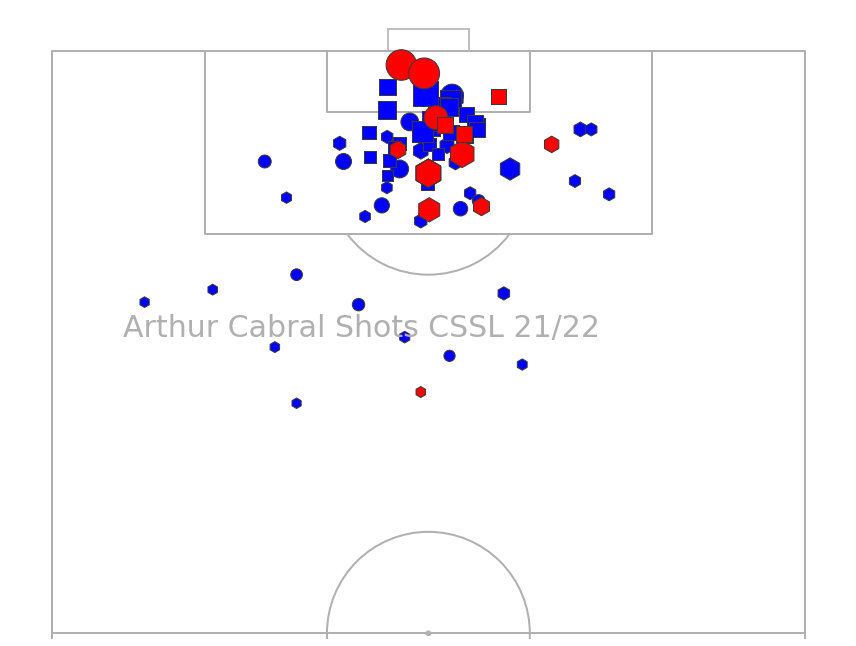

In [14]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
saved_right = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'expected_goals'] * 900) + 100, c='blue',edgecolors='#383838',marker='h', ax=ax)
saved_left = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'expected_goals'] * 900) + 100, c='blue',edgecolors='#383838',marker='o', ax=ax)
saved_left = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']!='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'expected_goals'] * 900) + 100, c='blue',edgecolors='#383838',marker='s', ax=ax)

goals = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'RightFoot'),'expected_goals'] * 900) + 100, c='red',edgecolors='#383838',marker='h', ax=ax)
goals = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'LeftFoot'),'expected_goals'] * 900) + 100, c='red',edgecolors='#383838',marker='o', ax=ax)
goals = pitch.scatter(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'x_coord'], df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'y_coord'], s=(df_cabral_shots.loc[(df_cabral_shots['event_type']=='Goal') & (df_cabral_shots['shot_type'] == 'Header'),'expected_goals'] * 900) + 100, c='red',edgecolors='#383838',marker='s', ax=ax)


txt = ax.text(x=40, y=80, s='Arthur Cabral Shots CSSL 21/22', size=30, color= pitch.line_color, va='center', ha='center')

# Shotmaps V2 
## prettier viz with help by Tutorial of Peter McKeever

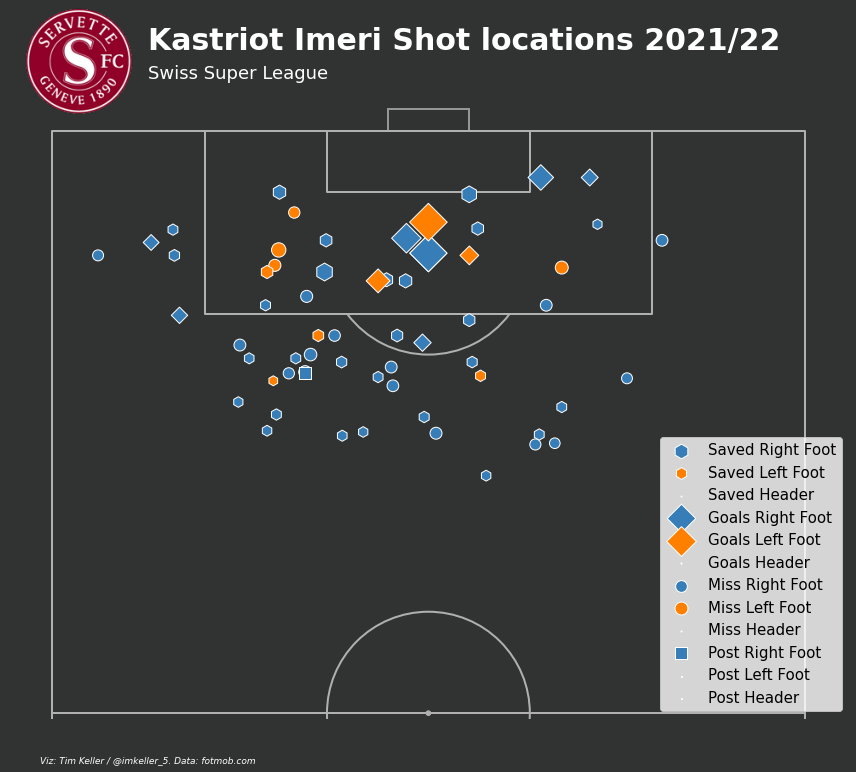

In [52]:
players = df_shots.loc[df_shots['event_type']=='Goal','player_name'].value_counts().head(10).index.tolist()
player = players[5]
season = "2021/22"
title_font = "Alegreya Sans"
body_font = "Open Sans"
text_color = "w"
background = "#313332"
edge = "white"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

saved_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='AttemptSaved') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='h', ax=ax, zorder=15)

miss_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Miss') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='o', ax=ax, zorder=5)

post_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='s', ax=ax, zorder=10)
post_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='s', ax=ax, zorder=10)
post_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Post') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='s', ax=ax, zorder=10)

goals_right = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='D', ax=ax, zorder=20)
goals_left = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='D', ax=ax, zorder=20)
goals_header = pitch.scatter(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'x_coord'], df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'y_coord'], s=(df_shots.loc[(df_shots['event_type']=='Goal') & (df_shots['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='D', ax=ax, zorder=20)


plt.legend(handles=[saved_right, saved_left, saved_header, goals_right, goals_left, goals_header, miss_right, miss_left, miss_header,post_right,post_left,post_header], labels=['Saved Right Foot', 'Saved Left Foot', 'Saved Header', 'Goals Right Foot', 'Goals Left Foot', 'Goals Header','Miss Right Foot','Miss Left Foot','Miss Header','Post Right Foot','Post Left Foot','Post Header'], loc='lower right', fontsize=10, prop={'size': 15})

ax2 = fig.add_axes([0.02,0.9,0.15,0.15]) # badge
ax2.axis('off')
url = team_logo_url[df_shots.loc[df_shots['player_name']==player,'team_short'].unique()[0]]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

fig.text(0.05, 0.0, "Viz: Tim Keller / @imkeller_5. Data: fotmob.com",
        fontstyle="italic",fontsize=9, fontfamily=body_font, color=text_color)

string = '{} Shot locations {}'.format(player,season)
fig.text(0.175,0.99,string, fontsize=30, fontfamily=title_font, color=text_color, fontweight='bold')
fig.text(0.175,0.95,'Swiss Super League', fontweight='regular',fontsize=18, fontfamily=title_font,color=text_color)


plt.tight_layout()
plt.show()

fig.savefig('figs/{}_shotmap.jpg'.format(player).lower().replace(' ','_'),bbox_inches='tight')

In [51]:
players

['Jordan Pefok',
 'Arthur Cabral',
 'Assan Ceesay',
 'Kwadwo Duah',
 'Antonio Marchesano',
 'Kastriot Imeri',
 'Zeki Amdouni',
 'Kaly Sene',
 'Wilfried Kanga',
 'Zan Celar']

In [16]:
df_cabral_shots['shot_type'].unique()

array(['Header', 'RightFoot', 'LeftFoot'], dtype=object)

In [17]:
df_cabral_shots['event_type'].unique()

array(['AttemptSaved', 'Miss', 'Goal', 'Post'], dtype=object)

In [18]:
df_cabral_shots.loc[df_cabral_shots['event_type']=='Goal']

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,period,is_own_goal,first_name,last_name,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short
264,264,2314959323,Goal,9931,670948,Arthur Cabral,98.342105,32.475000,44,0.0,...,FirstHalf,False,Arthur,Cabral,1.524471,0.215734,1.0,3623878,Basel,BAS
394,394,2316859251,Goal,9931,670948,Arthur Cabral,96.605260,22.878217,19,0.0,...,FirstHalf,False,Arthur,Cabral,1.665675,0.236118,1.0,3623883,Basel,BAS
400,400,2316878813,Goal,9931,670948,Arthur Cabral,94.000000,34.000000,45,0.0,...,FirstHalf,False,Arthur,Cabral,1.463955,0.064550,1.0,3623883,Basel,BAS
406,406,2316894399,Goal,9931,670948,Arthur Cabral,103.767238,36.440001,50,0.0,...,SecondHalf,False,Arthur,Cabral,0.657077,0.107018,1.0,3623883,Basel,BAS
410,410,2316903939,Goal,9931,670948,Arthur Cabral,99.017541,33.313749,63,0.0,...,SecondHalf,False,Arthur,Cabral,1.201720,0.183459,1.0,3623883,Basel,BAS
521,521,2322091787,Goal,9931,670948,Arthur Cabral,94.000000,34.000000,45,3.0,...,FirstHalf,False,Arthur,Cabral,1.867394,0.225926,1.0,3623887,Basel,BAS
531,531,2322115903,Goal,9931,670948,Arthur Cabral,100.922411,27.698572,59,0.0,...,SecondHalf,False,Arthur,Cabral,0.757937,0.074742,1.0,3623887,Basel,BAS
848,848,2329579515,Goal,9931,670948,Arthur Cabral,103.008622,34.381250,29,0.0,...,FirstHalf,False,Arthur,Cabral,0.798280,0.107018,1.0,3623899,Basel,BAS
925,925,2333562229,Goal,9931,670948,Arthur Cabral,96.122804,36.744999,15,0.0,...,FirstHalf,False,Arthur,Cabral,1.242063,0.516402,1.0,3623902,Basel,BAS
948,948,2333618821,Goal,9931,670948,Arthur Cabral,90.699997,33.923751,85,0.0,...,SecondHalf,False,Arthur,Cabral,1.544643,0.139293,1.0,3623902,Basel,BAS


In [19]:
df_cabral_shots.columns

Index(['Unnamed: 0', 'shot_id', 'event_type', 'team_id', 'player_id',
       'player_name', 'x_coord', 'y_coord', 'minutes', 'minutes_added',
       'is_blocked', 'is_on_target', 'blocked_x_coord', 'blocked_y_coord',
       'goal_crossed_y_coord', 'goal_crossed_z_coord', 'expected_goals',
       'expected_goals_on_target', 'shot_type', 'situation', 'period',
       'is_own_goal', 'first_name', 'last_name', 'on_goal_shot_x_coord',
       'on_goal_shot_y_coord', 'on_goal_shot_zoom_ratio', 'match_id', 'team',
       'team_short'],
      dtype='object')

In [20]:
df_cabral_shots.head()

,Unnamed: 0,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,...,period,is_own_goal,first_name,last_name,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short
94,94,2313151835,AttemptSaved,9931,670948,Arthur Cabral,95.157892,37.507499,30,0.0,...,FirstHalf,False,Arthur,Cabral,0.919312,0.290476,1.000000,3623873,Basel,BAS
97,97,2313154853,AttemptSaved,9931,670948,Arthur Cabral,97.666670,39.376905,39,0.0,...,FirstHalf,False,Arthur,Cabral,0.677249,0.344834,1.000000,3623873,Basel,BAS
108,108,2313174433,Miss,9931,670948,Arthur Cabral,97.473683,30.721251,81,0.0,...,SecondHalf,False,Arthur,Cabral,1.769048,0.677249,0.461324,3623873,Basel,BAS
110,110,2313176609,Miss,9931,670948,Arthur Cabral,94.385966,26.632188,85,0.0,...,SecondHalf,False,Arthur,Cabral,1.409119,0.677249,0.471665,3623873,Basel,BAS
112,112,2313178009,Miss,9931,670948,Arthur Cabral,100.637932,32.017501,88,0.0,...,SecondHalf,False,Arthur,Cabral,2.000000,0.391546,0.789379,3623873,Basel,BAS


# Erster Versuch Shots Heat Map 
## (in use case schwierig umsetzbar, kaum Aussagekräftig)

In [21]:
xdim, ydim = 50, 30 
shot_surface = np.zeros((xdim, ydim), dtype=np.float)
cabral_shot_surface = np.zeros((xdim, ydim), dtype=np.float)

In [22]:
shot_points= np.array([df_shots['x_coord'], df_shots['y_coord']]).T
cabral_shot_points = np.array([df_cabral_shots['x_coord'], df_cabral_shots['y_coord']]).T


In [23]:
x_bins = np.linspace(0,105, xdim)
y_bins = np.linspace(0,68, ydim)

In [24]:
for points, surface in [(shot_points, shot_surface),(cabral_shot_points, cabral_shot_surface)]:
    for x, y in points:
        x_index = np.digitize(x, x_bins)
        y_index = np.digitize(y, y_bins)
        try:
            surface[x_index, y_index] += 1 / len(points)
        except IndexError:
            pass

In [25]:
df_shots.columns

Index(['Unnamed: 0', 'shot_id', 'event_type', 'team_id', 'player_id',
       'player_name', 'x_coord', 'y_coord', 'minutes', 'minutes_added',
       'is_blocked', 'is_on_target', 'blocked_x_coord', 'blocked_y_coord',
       'goal_crossed_y_coord', 'goal_crossed_z_coord', 'expected_goals',
       'expected_goals_on_target', 'shot_type', 'situation', 'period',
       'is_own_goal', 'first_name', 'last_name', 'on_goal_shot_x_coord',
       'on_goal_shot_y_coord', 'on_goal_shot_zoom_ratio', 'match_id', 'team',
       'team_short'],
      dtype='object')

In [26]:
len(shot_points), len(cabral_shot_points)

(4144, 75)

In [27]:
shot_surface / len(shot_points)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

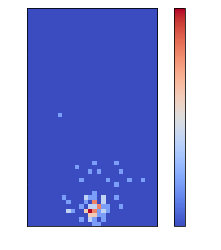

In [28]:
plt.imshow(cabral_shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

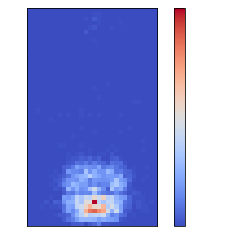

In [29]:
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

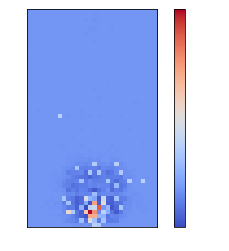

In [30]:
plt.imshow(cabral_shot_surface-shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

In [31]:
from scipy.ndimage import gaussian_filter

In [32]:
len(shot_surface), len(cabral_shot_surface)

(50, 50)

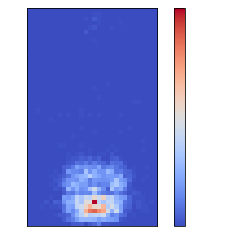

In [33]:
diff_cabral_shot_surface = gaussian_filter(cabral_shot_surface-shot_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

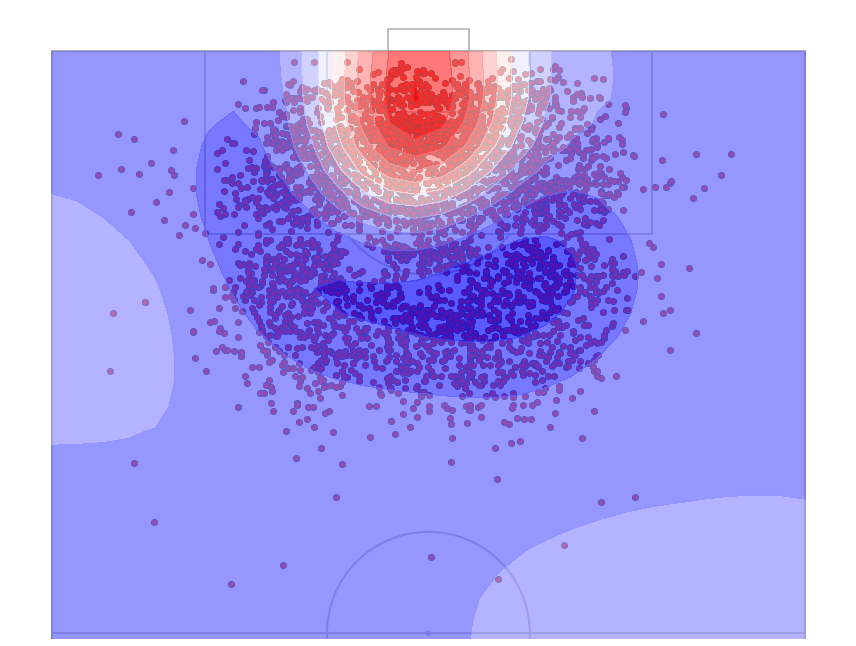

In [34]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
z = np.rot90(gaussian_filter(diff_cabral_shot_surface, sigma=2.2), 0)

ax.contourf(y_bins,x_bins, z, zorder=2, levels=10, alpha=0.7, cmap='bwr')

pitch.scatter(df_cabral_shots['x_coord'], df_cabral_shots['y_coord'], c='blue',edgecolors='#383838',marker='h', ax=ax)
pitch.scatter(df_cabral_shots['x_coord'], df_cabral_shots['y_coord'], c='blue',edgecolors='#383838',marker='o', ax=ax)

pitch.scatter(df_shots['x_coord'], df_shots['y_coord'], c='red',edgecolors='#383838',marker='h', ax=ax)
pitch.scatter(df_shots['x_coord'], df_shots['y_coord'], c='red',edgecolors='#383838',marker='o', ax=ax)


ax.set_aspect(1)
ax.axis('off')
plt.show()

# Shotmaps Teams

In [35]:
df_shots['team_short'].unique()

array(['YB', 'LUZ', 'GAL', 'LAU', 'LUG', 'ZUR', 'GRA', 'BAS', 'SER',
       'SIO'], dtype=object)

In [36]:
df_shots['situation'].unique()

array(['FromCorner', 'SetPiece', 'RegularPlay', 'FreeKick', 'FastBreak',
       'Penalty', 'ThrowInSetPiece', 'IndividualPlay'], dtype=object)

In [37]:
xdim, ydim = 50, 30 
league_shot_surface = np.zeros((xdim, ydim), dtype=np.float)
team_shot_surface = np.zeros((xdim, ydim), dtype=np.float)
team = 'LUG'
team_shot_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'expected_goals']]).T
league_shot_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'expected_goals']]).T
x_bins = np.linspace(0,105, xdim)
y_bins = np.linspace(0,68, ydim)

In [38]:
for points, surface in [(league_shot_points, league_shot_surface),(team_shot_points, team_shot_surface)]:
    
    for x, y, xg in points:
        x_index = np.digitize(x, x_bins)
        y_index = np.digitize(y, y_bins)
        try:
            surface[x_index, y_index] += 1 * xg / len(points)
        except IndexError:
            pass

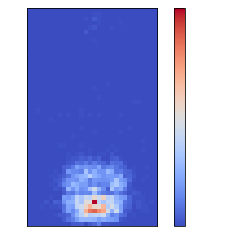

In [39]:
diff_team_shot_surface = gaussian_filter(team_shot_surface-league_shot_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

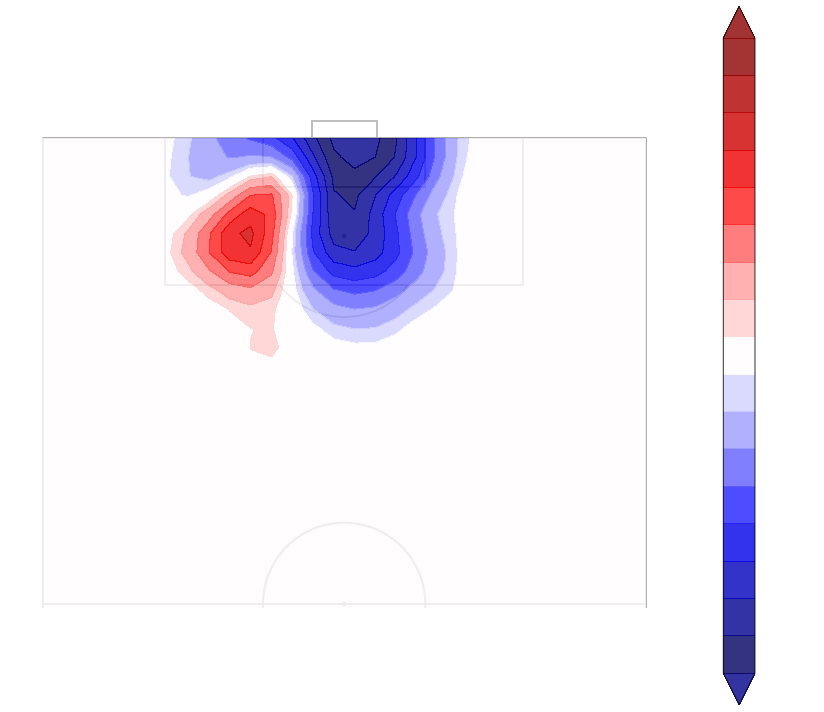

In [40]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
z = diff_team_shot_surface
levels = [-0.0004,-0.00035,-0.0003,-0.00025,-0.0002,-0.00015,-0.0001,-0.00005,-0.000025,0.000025,0.00005,0.0001,0.00015,0.0002,0.00025,0.0003,0.00035,0.0004]
sm = ax.contourf(y_bins,x_bins, z, zorder=2, levels=levels, alpha=0.8, cmap='seismic', extend='both')
sm.cmap.set_under('darkblue')
sm.cmap.set_over('darkred')
ax.set_aspect(1)
ax.axis('off')

cbar = fig.colorbar(sm)

plt.show()
fig.savefig('figs/{}-shotmap.jpg'.format(team.lower()),bbox_inches='tight')

- BAS: -0.00016, 0.00000
- YB : -0.00038, 0.00016
- ZUR: -0.00040, 0.00032
- GAL: -0.00035, 0.00005

## Shotmaps Finishing


In [41]:
league_shot_fin_surface = np.zeros((xdim, ydim), dtype=np.float)
team_shot_fin_surface = np.zeros((xdim, ydim), dtype=np.float)

In [42]:
team_shot_fin_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'expected_goals'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty')& (df_shots['team_short'] ==team),'event_type']]).T
league_shot_fin_points = np.array([df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'x_coord'], df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'y_coord'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'expected_goals'],df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),'event_type']]).T

In [43]:
for points, surface in [(league_shot_fin_points, league_shot_fin_surface),(team_shot_fin_points, team_shot_fin_surface)]:
    
    for x, y, xg, type in points:
        x_index = np.digitize(x, x_bins)
        y_index = np.digitize(y, y_bins)
        try:
            if type == 'Goal':
                surface[x_index, y_index] += (1 - xg) / len(points)
            else: 
                surface[x_index, y_index] -= xg / len(points)
        except IndexError:
            pass

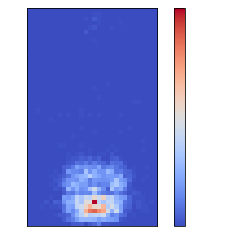

In [44]:
league_shot_fin = gaussian_filter(league_shot_fin_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

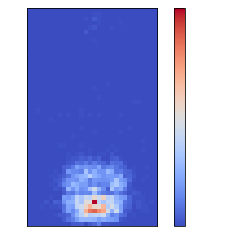

In [45]:
team_shot_fin = gaussian_filter(team_shot_fin_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

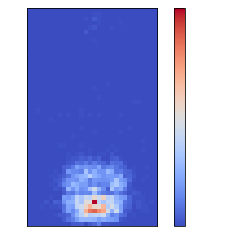

In [46]:
diff_team_fin_surface = gaussian_filter(team_shot_fin_surface-league_shot_fin_surface, sigma=1.5)
plt.imshow(shot_surface,cmap='coolwarm')
plt.colorbar()
plt.show()

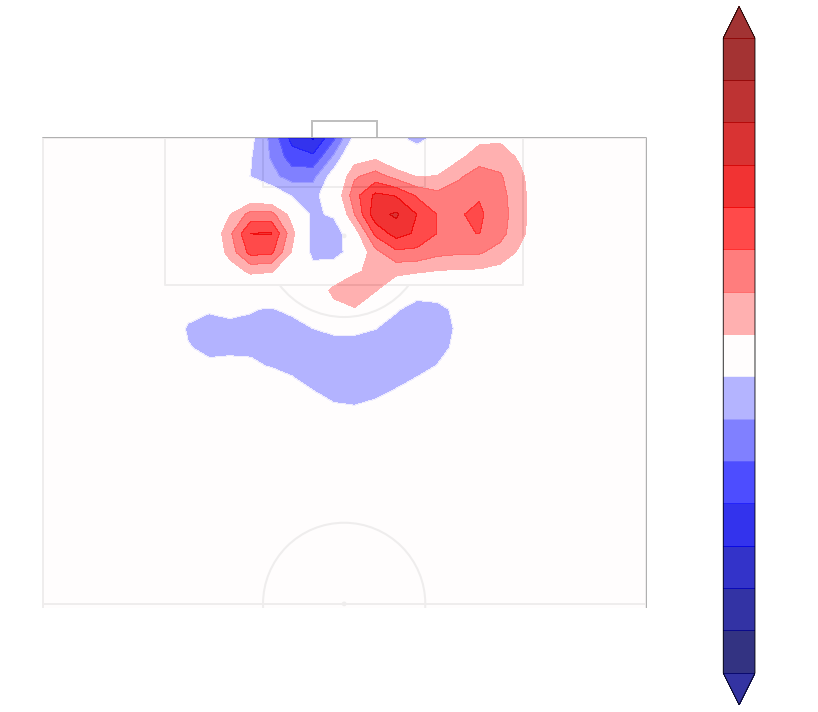

In [47]:
pitch = VerticalPitch('uefa',pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(12,10))
z = diff_team_fin_surface
levels=[-0.00048,-0.00042,-0.00036,-0.00030,-0.00024,-0.00018,-0.00012,-0.00006,0.00006,0.00012,0.00018,0.00024,0.00030,0.00036,0.00042,0.00048]
smf = ax.contourf(y_bins,x_bins, z, zorder=2, levels=levels, alpha=0.8, cmap='seismic', extend='both')
smf.cmap.set_under('darkblue')
smf.cmap.set_over('darkred')
ax.set_aspect(1)
ax.axis('off')
cbar = fig.colorbar(smf)

plt.show()


fig.savefig('figs/{}-finishing-shotmap.jpg'.format(team.lower()),bbox_inches='tight')

- BAS: -0.00016, 0.00012
- YB : -0.00036, 0.00024
- ZUR: -0.0001, 0.0006
- GAL: -0.0006, 0.0002

In [48]:
[-48,24,12,0,12,24,36,48]

[-48, 24, 12, 0, 12, 24, 36, 48]

In [49]:
df_shots.loc[df_shots['event_type']=='Goal','player_name'].value_counts().head(10).index.tolist()

['Jordan Pefok',
 'Arthur Cabral',
 'Assan Ceesay',
 'Kwadwo Duah',
 'Antonio Marchesano',
 'Kastriot Imeri',
 'Zeki Amdouni',
 'Kaly Sene',
 'Wilfried Kanga',
 'Zan Celar']

In [50]:
df_shots['event_type'].value_counts()

AttemptSaved    1952
Miss            1646
Goal             472
Post              74
Name: event_type, dtype: int64